1. Import các thư viện cần thiết


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

2. Load dataset

In [30]:
dataset_path = '../../Dataset/shopping_behavior_updated.csv'  
data = pd.read_csv(dataset_path)

3. Kiểm tra một vài thông tin của dataset

In [31]:
print("Dataset Head:")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nDataset Description:")
print(data.describe())

Dataset Head:
   Customer ID  Age Gender Item Purchased  Category  Purchase Amount (USD)  \
0            1   55   Male         Blouse  Clothing                     53   
1            2   19   Male        Sweater  Clothing                     64   
2            3   50   Male          Jeans  Clothing                     73   
3            4   21   Male        Sandals  Footwear                     90   
4            5   45   Male         Blouse  Clothing                     49   

        Location Size      Color  Season  Review Rating Subscription Status  \
0       Kentucky    L       Gray  Winter            3.1                 Yes   
1          Maine    L     Maroon  Winter            3.1                 Yes   
2  Massachusetts    S     Maroon  Spring            3.1                 Yes   
3   Rhode Island    M     Maroon  Spring            3.5                 Yes   
4         Oregon    M  Turquoise  Spring            2.7                 Yes   

   Shipping Type Payment Method Frequency 

4. Tiền xử lí dữ liệu

Xử lí trong trường hợp dữ liệu bị thiếu

In [32]:
numeric_cols = data.select_dtypes(include=['number']).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

In [33]:
non_numeric_cols = data.select_dtypes(exclude=['number']).columns
for col in non_numeric_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

4.1. Tạo cột Spending Category & Age Group target

In [34]:
data['AgeGroup'] = data['Age'].apply(lambda x: 'Young' if x < 30 else ('Middle-aged' if x < 60 else 'Senior'))


In [ ]:
bins = [0, 50, 100, data['Purchase Amount (USD)'].max() + 1]  # Thêm 1 vào giá trị lớn nhất (Tại sao???, bins này có ý nghĩa gì)
labels = ['Low', 'Medium', 'High']  # Nhãn cho các nhóm
data['SpendingCategory'] = pd.cut(data['Purchase Amount (USD)'], bins=bins, labels=labels)


In [36]:
# Chuẩn bị dữ liệu
features = ['Season', 'AgeGroup']  # Kết hợp Season và AgeGroup
X = pd.get_dummies(data[features])  # Mã hóa one-hot cho các đặc trưng
y = data['SpendingCategory']  # Mục tiêu là Spending Category

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Đảm bảo tất cả các cột trong X_train là kiểu float
X_train = X_train.astype(float)


In [ ]:
from imblearn.over_sampling import SMOTE

# Áp dụng SMOTE để xử lý dữ liệu mất cân bằng
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Kiểm tra kích thước dữ liệu sau khi áp dụng SMOTE
print("Kích thước dữ liệu trước khi áp dụng SMOTE:", X_train.shape)
print("Kích thước dữ liệu sau khi áp dụng SMOTE:", X_resampled.shape)



Kích thước dữ liệu trước khi áp dụng SMOTE: (3120, 7)
Kích thước dữ liệu sau khi áp dụng SMOTE: (3864, 7)


In [44]:
# Huấn luyện mô hình Decision Tree với dữ liệu đã được cân bằng
model = DecisionTreeClassifier(random_state=42, max_depth=8, min_samples_split=5)
model.fit(X_resampled, y_resampled)

# Dự đoán và đánh giá
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='f1_macro')
print("F1 Macro Average:", scores.mean())

Accuracy: 0.5025641025641026

Classification Report:
               precision    recall  f1-score   support

         Low       0.39      0.33      0.36       326
      Medium       0.57      0.62      0.59       454

    accuracy                           0.50       780
   macro avg       0.48      0.48      0.48       780
weighted avg       0.49      0.50      0.50       780

F1 Macro Average: 0.5247460213965084


Sử dụng plot_tree để vẽ cây quyết định:



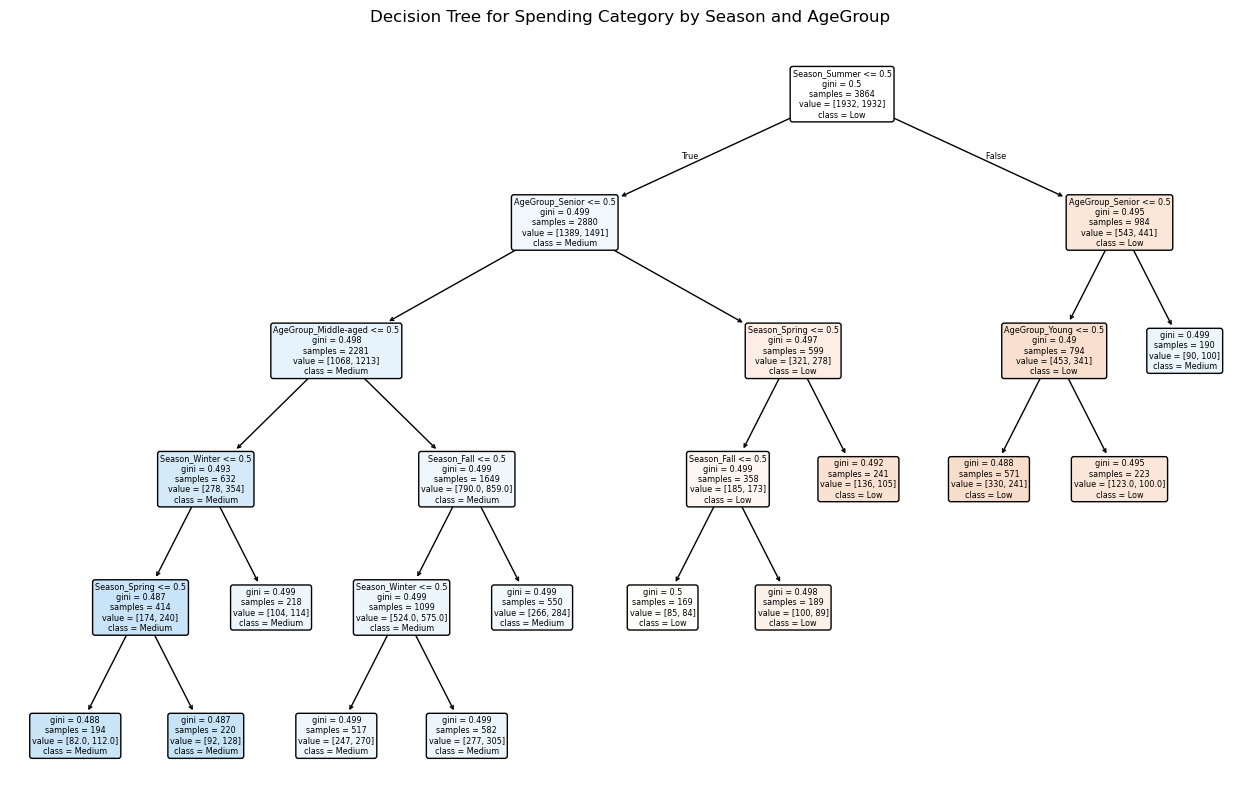

In [45]:
# Vẽ cây quyết định
plt.figure(figsize=(16, 10))
plot_tree(model, feature_names=X.columns, class_names=model.classes_, filled=True, rounded=True)
plt.title("Decision Tree for Spending Category by Season and AgeGroup")
plt.show()

Đánh giá độ chính xác của mô hình và hiệu suất phân loại:



In [46]:
# Dự đoán và đánh giá
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5025641025641026

Classification Report:
               precision    recall  f1-score   support

         Low       0.39      0.33      0.36       326
      Medium       0.57      0.62      0.59       454

    accuracy                           0.50       780
   macro avg       0.48      0.48      0.48       780
weighted avg       0.49      0.50      0.50       780



### Phân tích cây quyết định cho `Spending Category` theo `Season` và `AgeGroup`

Cây quyết định này được xây dựng để dự đoán nhóm chi tiêu (`Spending Category`: `Low`, `Medium`, `High`) dựa trên các đặc trưng `Season` và `AgeGroup`. Dưới đây là phân tích chi tiết:

---

### 1. Phân tích cấu trúc cây quyết định

#### a. Nút gốc (Root Node):
- **Điều kiện phân chia đầu tiên**: `Season_Summer <= 0.5`
  - Đây là đặc trưng quan trọng nhất, cho thấy mùa (`Season`) là yếu tố chính ảnh hưởng đến hành vi chi tiêu.
  - Nếu không phải mùa `Summer` (`Season_Summer <= 0.5`), cây tiếp tục phân chia dựa trên `AgeGroup`.

#### b. Nhánh trái (Không phải mùa `Summer`):
- **Điều kiện tiếp theo**: `AgeGroup_Senior <= 0.5`
  - Điều này cho thấy nhóm tuổi (`AgeGroup`) là yếu tố quan trọng thứ hai.
  - Nếu không phải nhóm `Senior`, cây tiếp tục phân chia dựa trên `AgeGroup_Middle-Aged` và `Season`.

#### c. Nhánh phải (Mùa `Summer`):
- **Điều kiện tiếp theo**: `AgeGroup_Senior <= 0.5`
  - Trong mùa `Summer`, nhóm tuổi (`AgeGroup`) tiếp tục là yếu tố quan trọng để phân loại chi tiêu.

---

### 2. Phân tích các nút lá (Leaf Nodes)

#### a. Nhóm chi tiêu `Medium` chiếm ưu thế:
- Trong hầu hết các nút lá, nhóm chi tiêu `Medium` chiếm ưu thế, cho thấy phần lớn khách hàng có mức chi tiêu trung bình.

#### b. Nhóm chi tiêu `Low` và `High`:
- Một số nút lá có sự phân hóa rõ ràng hơn, ví dụ:
  - **Nhóm `Low`**: Xuất hiện ở các nhánh có điều kiện liên quan đến nhóm tuổi `Senior` và mùa `Spring`.
  - **Nhóm `High`**: Không xuất hiện rõ ràng trong cây này, có thể do dữ liệu không đủ để phân biệt nhóm chi tiêu cao.

---

### 3. Ý nghĩa thực tiễn từ cây quyết định

#### a. Mùa (`Season`) là yếu tố quan trọng nhất:
- Điều kiện phân chia đầu tiên là `Season_Summer <= 0.5`, cho thấy mùa có ảnh hưởng lớn đến hành vi chi tiêu.
- **Thực tiễn**:
  - Trong mùa `Summer`, doanh nghiệp nên tập trung vào các sản phẩm phù hợp với mùa hè, như thời trang mùa hè, đồ du lịch, hoặc các sản phẩm giải trí.

#### b. Nhóm tuổi (`AgeGroup`) là yếu tố quan trọng thứ hai:
- Nhóm tuổi (`AgeGroup_Senior` và `AgeGroup_Middle-Aged`) được sử dụng để phân chia tiếp theo, cho thấy hành vi chi tiêu khác nhau giữa các nhóm tuổi.
- **Thực tiễn**:
  - Nhóm `Middle-Aged` có xu hướng chi tiêu trung bình (`Medium`), doanh nghiệp có thể tập trung vào các sản phẩm cao cấp hoặc đồ gia dụng.
  - Nhóm `Senior` có xu hướng chi tiêu thấp hơn, doanh nghiệp có thể triển khai các chương trình khuyến mãi hoặc giảm giá để kích thích chi tiêu.

#### c. Mùa `Winter` và `Spring` có sự phân hóa rõ ràng hơn:
- Trong các mùa này, cây quyết định tiếp tục phân chia dựa trên nhóm tuổi, cho thấy hành vi chi tiêu trong các mùa này phụ thuộc nhiều vào độ tuổi.
- **Thực tiễn**:
  - Trong mùa `Winter`, doanh nghiệp nên tập trung vào các sản phẩm mùa đông như áo khoác, giày ấm, hoặc các sản phẩm liên quan đến lễ hội.
  - Trong mùa `Spring`, doanh nghiệp có thể cần các chương trình kích cầu để tăng chi tiêu.

---

### 4. Hạn chế và hướng cải thiện

#### a. Hạn chế:
- Nhóm chi tiêu `High` không xuất hiện rõ ràng trong cây, có thể do dữ liệu không đủ để phân biệt nhóm này.
- Giá trị `gini` ở một số nút vẫn còn cao, cho thấy dữ liệu chưa được phân chia hoàn toàn thuần nhất.

#### b. Hướng cải thiện:
- Thêm các đặc trưng khác như `Category`, `Gender`, hoặc `Payment Method` để cải thiện khả năng phân loại.
- Sử dụng các thuật toán khác như Random Forest để tăng độ chính xác và giảm overfitting.

---

### 5. Kết luận thực tiễn

#### a. Mùa `Summer` và nhóm `Middle-Aged`:
- Đây là phân khúc khách hàng tiềm năng với mức chi tiêu trung bình. Doanh nghiệp nên tập trung vào các sản phẩm phù hợp với mùa hè và nhu cầu của nhóm tuổi trung niên.

#### b. Mùa `Winter` và nhóm `Senior`:
- Nhóm này có xu hướng chi tiêu thấp hơn, doanh nghiệp có thể triển khai các chương trình khuyến mãi hoặc giảm giá để kích thích chi tiêu.

#### c. Tối ưu hóa chiến lược theo mùa:
- Tăng cường quảng cáo và khuyến mãi trong mùa `Winter` và `Summer`, nơi có sự phân hóa rõ ràng về hành vi chi tiêu.
- Kích cầu trong mùa `Spring` bằng các chương trình giảm giá hoặc ưu đãi.

Cây quyết định này cung cấp thông tin hữu ích để doanh nghiệp tối ưu hóa chiến lược kinh doanh và tiếp thị theo mùa và nhóm tuổi.